Imports

In [29]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    roc_curve,
    auc
)

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier






Load the dataset

In [30]:
# Get the parent directory (DS3000-Group-4) and navigate to Data
current_dir = os.getcwd()
data_path = os.path.join(os.path.dirname(current_dir), 'Data', 'mxmh_survey_results.csv')

df = pd.read_csv(data_path) # Load the dataset
df = df.drop(columns=['Exploratory', 'Timestamp', 
                      'Primary streaming service', 'BPM', 'Music effects', 'Permissions']) # Drop unnecessary columns
df = df.dropna() # Drop rows with any missing values
df.head() # Display the first few rows of the cleaned dataset

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD
0,18.0,3.0,Yes,Yes,Yes,Latin,Yes,Rarely,Never,Rarely,...,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0
1,63.0,1.5,Yes,No,No,Rock,No,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0
2,18.0,4.0,No,No,No,Video game music,Yes,Never,Never,Very frequently,...,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0
3,61.0,2.5,Yes,No,Yes,Jazz,Yes,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0
4,18.0,4.0,Yes,No,No,R&B,No,Never,Never,Rarely,...,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0


Visualise distribution of genre preferences

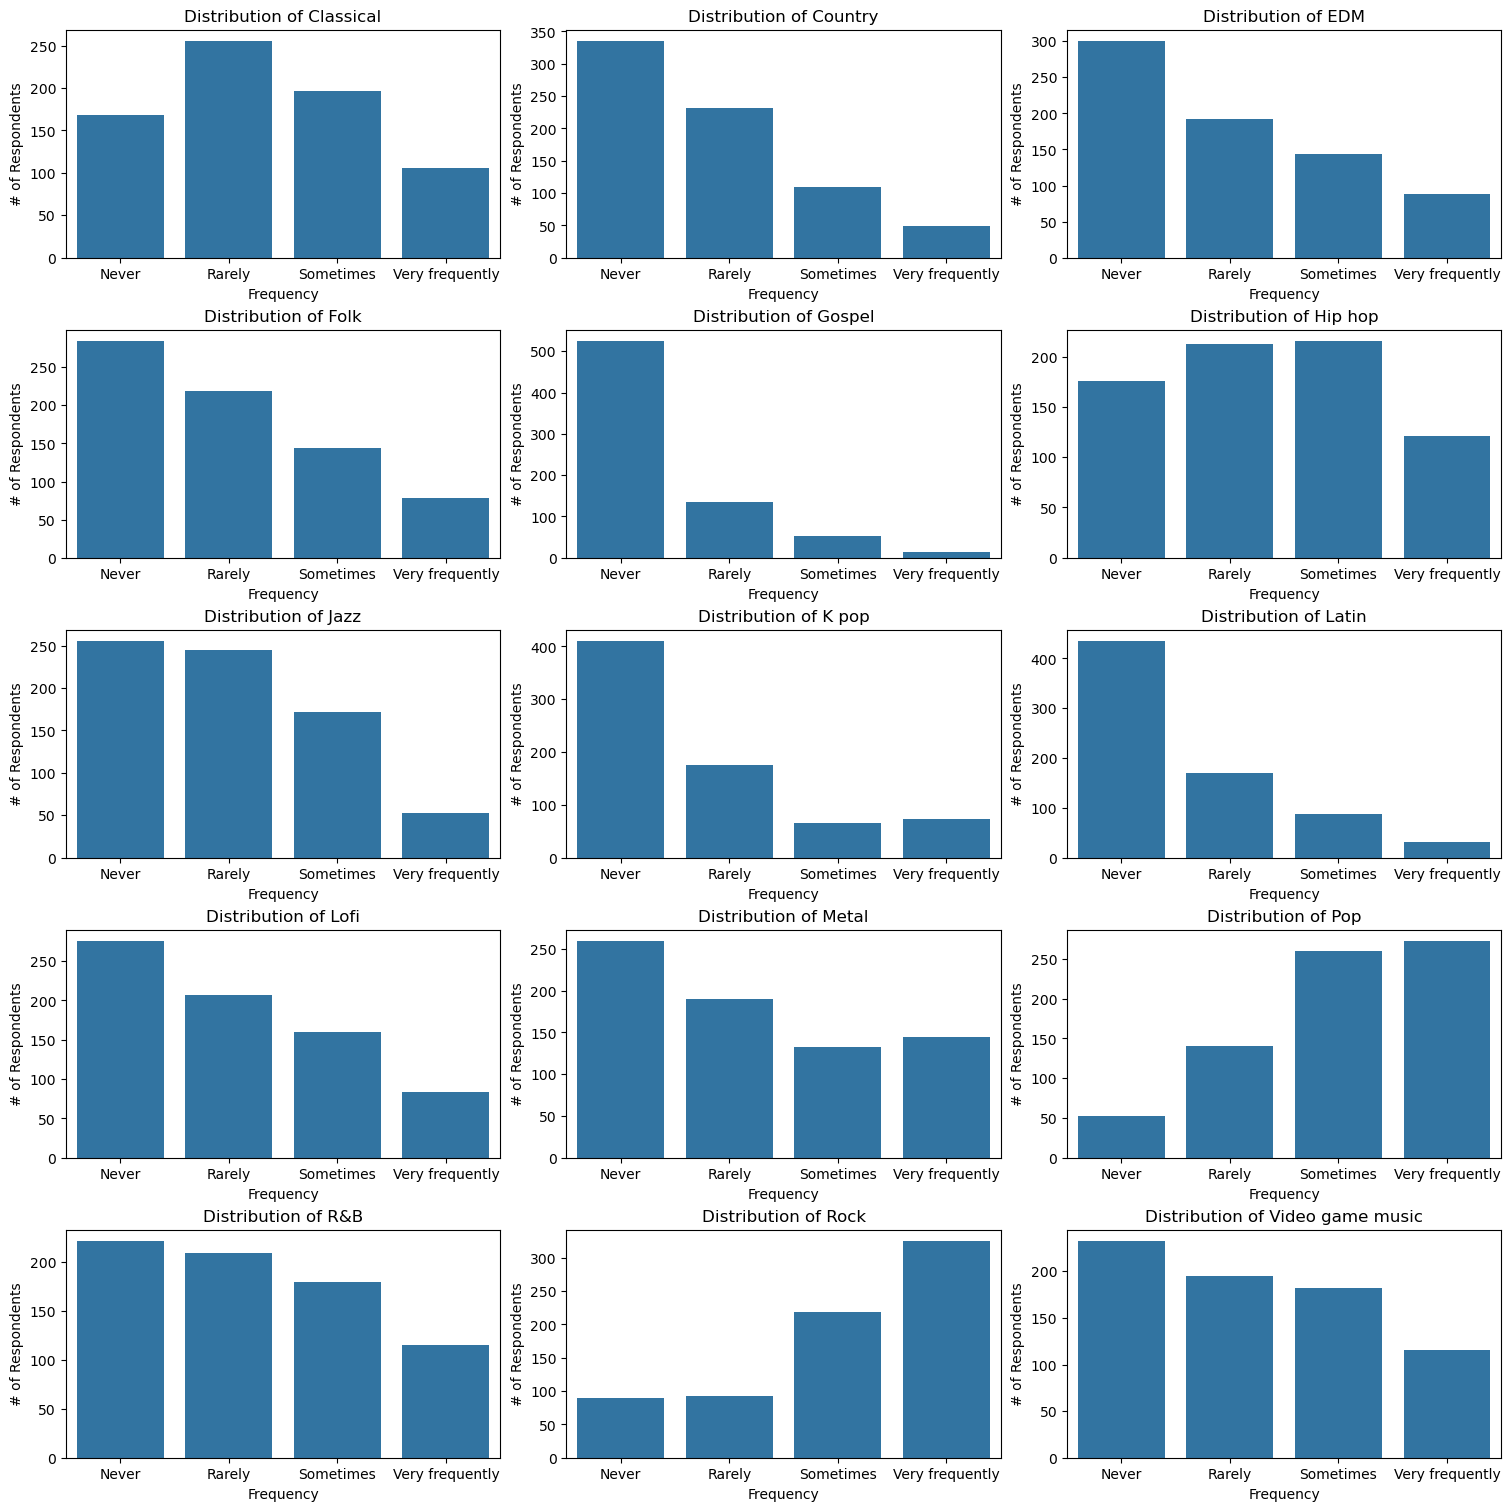

In [31]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of each genre frequency in a grid
mh_condition = ['Classical', 'Country', 'EDM', 'Folk', 'Gospel', 'Hip hop', 'Jazz', 'K pop',
                 'Latin', 'Lofi', 'Metal', 'Pop', 'R&B', 'Rock', 'Video game music']

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'Frequency [{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for genre '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No genre columns found to plot")

# Frequency order
freq_order = ['Never', 'Rarely', 'Sometimes', 'Very frequently']

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    s = df[col].dropna()
    # Ensure categorical with explicit order
    s = pd.Categorical(s, categories=freq_order, ordered=True)
    sns.countplot(x=s, ax=ax, color='C0', order=freq_order)
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Frequency [', '').replace(']', '')
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()


In [32]:
# Drop gospel, as we do not have enough data points on those who listen to it sometimes or very frequently
df = df.drop(columns=['Frequency [Gospel]'])

Visualise dsitribution of Other Features

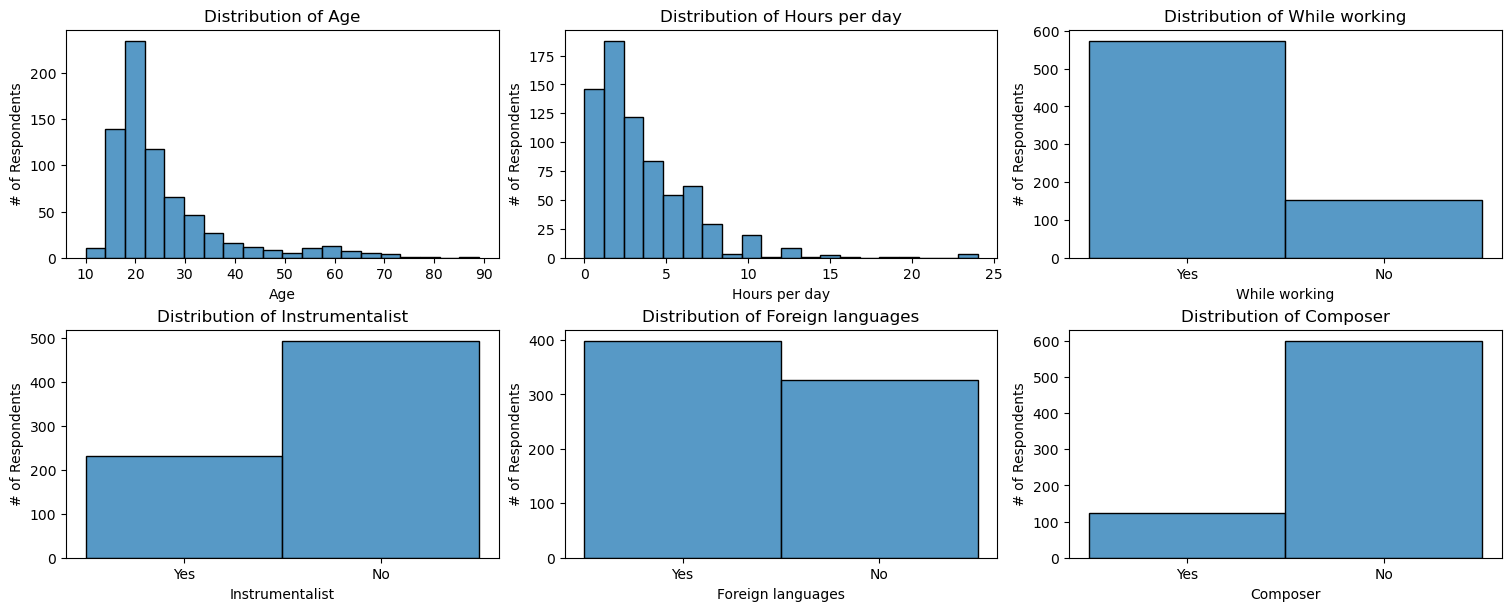

In [33]:
# Plot the distribution of Non-Genre Features
mh_condition = ['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Foreign languages', 'Composer' ]

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'[{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for feature '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No feature columns found to plot")

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    sns.histplot(df[col].dropna(), bins=20, kde=False, ax=ax, color='C0')
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Frequency [', '').replace(']', '')
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel(col)
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()    

Visualise the distribution of mental health conditions

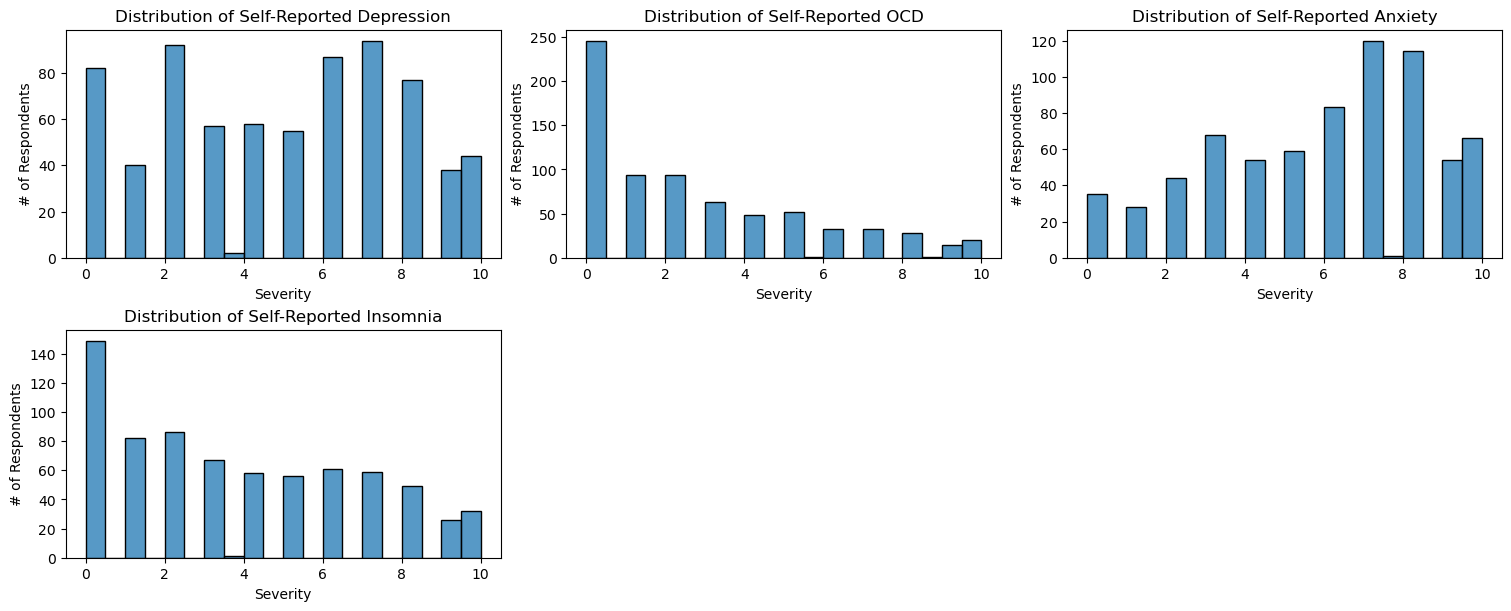

In [34]:
import math
import numpy as np

# Plot the distribution of each genre frequency in a grid
mh_condition = ['Depression', 'OCD', 'Anxiety', 'Insomnia' ]

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'[{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for genre '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No MH columns found to plot")

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    sns.histplot(df[col].dropna(), bins=20, kde=False, ax=ax, color='C0')
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Severity [', '').replace(']', '')
    ax.set_title(f'Distribution of Self-Reported {title}')
    ax.set_xlabel('Severity')
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()

We see that we do not have many respondants reporting symptoms of OCD. Therefore, we may not be able to accurately model music-factor trends relating to higher/lower levels of OCD.

We notice that most respondants experience moderate to high anxiety.

We notice that we have good balance of respondants experiencing various levels of depression. We may have more success forecasting this.

In [35]:
# Frame mental health condition columns as classification targets
mh_condition = ['Depression', 'OCD', 'Anxiety', 'Insomnia' ]

def to_3class(score_series):
    """
    Map numeric scores to 3 classes:
    0–3  -> 0 (Low)
    4–6  -> 1 (Moderate)
    7–10 -> 2 (High)
    """
    bins = [-np.inf, 3.0, 6.0, np.inf] # Define class bin edges
    labels = [0, 1, 2] # Corresponding class labels
    return pd.cut(score_series, bins=bins, labels=labels).astype(int) # Convert to int type


# Convert target columns if they exist
target_conditions = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
for t in target_conditions:
    if t in df.columns:
        df[f"{t}_class"] = to_3class(df[t])

# Drop original target columns if they exist
existing_targets = [t for t in target_conditions if t in df.columns]
if existing_targets:
    df = df.drop(columns=existing_targets)    

df.head()


,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety_class,Depression_class,Insomnia_class,OCD_class
0,18.0,3.0,Yes,Yes,Yes,Latin,Yes,Rarely,Never,Rarely,...,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,0,0,0,0
1,63.0,1.5,Yes,No,No,Rock,No,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,2,0,0,0
2,18.0,4.0,No,No,No,Video game music,Yes,Never,Never,Very frequently,...,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,2,2,2,0
3,61.0,2.5,Yes,No,Yes,Jazz,Yes,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Never,Never,Never,2,2,0,0
4,18.0,4.0,Yes,No,No,R&B,No,Never,Never,Rarely,...,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,2,0,1,2


In [36]:
# Convert favourite genre into a boost applied to the users favourite genre frequency
import pandas as pd

# Define frequency mapping
freq_map = {
    "Never": 0,
    "Rarely": 1,
    "Sometimes": 2,
    "Frequently": 3,
    "Very frequently": 4
}

# Copy df to avoid mutating original
df_fe = df.copy()

# Identify genre frequency columns
freq_cols = [col for col in df.columns if col.startswith("Frequency")]


# Convert frequency columns to numeric using the mapping
for col in freq_cols:
    df_fe[col] = df_fe[col].map(freq_map).astype(float)


# Create a normalised genre name lookup so "Fav genre" matches frequency column names
# Example: "Rock" → "Frequency [Rock]"
def genre_to_freq_column(genre):
    return f"Frequency [{genre}]"

BOOST_AMOUNT = 1.0   # You may tune this later

def convert_fav_genre_to_freq_col(genre):
    """Convert 'Rock' → 'Frequency [Rock]'."""
    return f"Frequency [{genre}]"

for idx, row in df_fe.iterrows():
    fav = row["Fav genre"]
    target_col = convert_fav_genre_to_freq_col(fav)

    if target_col in freq_cols:
        df_fe.loc[idx, target_col] = df_fe.loc[idx, target_col] + BOOST_AMOUNT

# Drop original Fav genre column if model should not see it
df_fe = df_fe.drop(columns=["Fav genre"])

# Display the processed dataframe
df_fe.head()


,Age,Hours per day,While working,Instrumentalist,Composer,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety_class,Depression_class,Insomnia_class,OCD_class
0,18.0,3.0,Yes,Yes,Yes,Yes,1.0,0.0,1.0,0.0,...,0.0,4.0,2.0,4.0,0.0,2.0,0,0,0,0
1,63.0,1.5,Yes,No,No,No,2.0,0.0,0.0,1.0,...,0.0,2.0,2.0,1.0,5.0,1.0,2,0,0,0
2,18.0,4.0,No,No,No,Yes,0.0,0.0,4.0,0.0,...,2.0,1.0,0.0,1.0,1.0,5.0,2,2,2,0
3,61.0,2.5,Yes,No,Yes,Yes,2.0,0.0,0.0,1.0,...,0.0,2.0,2.0,0.0,0.0,0.0,2,2,0,0
4,18.0,4.0,Yes,No,No,No,0.0,0.0,1.0,0.0,...,0.0,2.0,5.0,4.0,0.0,1.0,2,0,1,2


In [37]:
# Start from a clean copy of the original dataframe
df_fe1 = df_fe.copy()

# Clean col names to avoid key errors
df_fe1.columns = (
    df_fe1.columns.astype(str)
    .str.strip()
    .str.replace('\xa0', '', regex=False)
    .str.replace(r'\s+', ' ', regex=True)
)

print("Cleaned column names:", df_fe1.columns.tolist())

# Define age group bins and labels
age_bins = [0, 17, 25, 35, 45, 55, 65, np.inf]
age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

if 'Age' not in df_fe1.columns:
    raise KeyError("'Age' column not found in dataframe.")

# Create Age Group categorical feature
df_fe1['Age Group'] = pd.cut(
    df_fe1['Age'], bins=age_bins, labels=age_labels
)

# One-hot encode Age Group (categorical, not ordinal!)
df_fe1 = pd.get_dummies(df_fe1, columns=['Age Group'], prefix='AgeGroup')

# Drop the original Age column if not needed
df_fe1 = df_fe1.drop(columns=['Age'])

# AUTO-DETECT YES/NO COLUMNS
yes_no_cols = []
for col in df_fe1.columns:
    nonnull = df_fe1[col].dropna().unique()
    if len(nonnull) > 0 and set(nonnull).issubset({'Yes', 'No'}):
        yes_no_cols.append(col)
    if len(nonnull) > 0 and set(nonnull).issubset({'True', 'False'}):
        yes_no_cols.append(col)

print("Detected Yes/No columns:", yes_no_cols)

# Convert boolean to binary 1/0
for col in yes_no_cols:
    df_fe1[col] = df_fe1[col].map({'Yes': 1, 'No': 0, 'True': 1, 'False': 0})

df_fe1.head(10)


Cleaned column names: ['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Composer', 'Foreign languages', 'Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]', 'Frequency [Hip hop]', 'Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]', 'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]', 'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]', 'Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class']
Detected Yes/No columns: ['While working', 'Instrumentalist', 'Composer', 'Foreign languages']


,Hours per day,While working,Instrumentalist,Composer,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Hip hop],...,Depression_class,Insomnia_class,OCD_class,AgeGroup_<18,AgeGroup_18-24,AgeGroup_25-34,AgeGroup_35-44,AgeGroup_45-54,AgeGroup_55-64,AgeGroup_65+
0,3.0,1,1,1,1,1.0,0.0,1.0,0.0,2.0,...,0,0,0,False,True,False,False,False,False,False
1,1.5,1,0,0,0,2.0,0.0,0.0,1.0,1.0,...,0,0,0,False,False,False,False,False,True,False
2,4.0,0,0,0,1,0.0,0.0,4.0,0.0,1.0,...,2,2,0,False,True,False,False,False,False,False
3,2.5,1,0,1,1,2.0,0.0,0.0,1.0,0.0,...,2,0,0,False,False,False,False,False,True,False
4,4.0,1,0,0,0,0.0,0.0,1.0,0.0,4.0,...,0,1,2,False,True,False,False,False,False,False
5,5.0,1,1,1,1,1.0,2.0,0.0,0.0,2.0,...,2,2,2,False,True,False,False,False,False,False
6,3.0,1,1,0,1,2.0,0.0,1.0,2.0,1.0,...,2,1,0,False,True,False,False,False,False,False
7,1.0,1,0,0,1,0.0,0.0,1.0,0.0,4.0,...,0,1,0,False,True,False,False,False,False,False
8,6.0,1,0,0,0,0.0,4.0,0.0,2.0,0.0,...,0,0,0,False,True,False,False,False,False,False
9,1.0,1,0,0,1,1.0,1.0,1.0,1.0,1.0,...,0,1,0,False,True,False,False,False,False,False


In [38]:
'''# Start from a clean copy of the original dataframe
df_fe1 = df_fe.copy()

# Clean col names to avoid key errors
df_fe1.columns = (
    df_fe1.columns.astype(str)
    .str.strip()
    .str.replace('\xa0', '', regex=False)
    .str.replace(r'\s+', ' ', regex=True)
)

print("Cleaned column names:", df_fe1.columns.tolist())

# Cretae age groups
age_bins = [0, 17, 25, 35, 45, 55, 65, np.inf] # Define age group bins
age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+'] # Define age group labels

if 'Age' not in df_fe1.columns:
    raise KeyError("'Age' column not found in dataframe.")

# Create Age Group categorical feature
df_fe1['Age Group'] = pd.cut(
    df_fe1['Age'], bins=age_bins, labels=age_labels
)

# Encode Age Group as ordinal integers
df_fe1['Age Group Encoded'] = df_fe1['Age Group'].cat.codes

# Drop the original Age column if not needed
df_fe1 = df_fe1.drop(columns=['Age Group'])  # keep encoded only
df_fe1 = df_fe1.drop(columns=['Age'])  # keep encoded only

# AUTO-DETECT YES/NO COLUMNS
yes_no_cols = []
for col in df_fe1.columns:
    nonnull = df_fe1[col].dropna().unique()
    if len(nonnull) > 0 and set(nonnull).issubset({'Yes', 'No'}):
        yes_no_cols.append(col)

print("Detected Yes/No columns:", yes_no_cols)

# Convert boolean to binary 1/0
for col in yes_no_cols:
    df_fe1[col] = df_fe1[col].map({'Yes': 1, 'No': 0})

df_fe1.head(10)'''


'# Start from a clean copy of the original dataframe\ndf_fe1 = df_fe.copy()\n\n# Clean col names to avoid key errors\ndf_fe1.columns = (\n    df_fe1.columns.astype(str)\n    .str.strip()\n    .str.replace(\'\xa0\', \'\', regex=False)\n    .str.replace(r\'\\s+\', \' \', regex=True)\n)\n\nprint("Cleaned column names:", df_fe1.columns.tolist())\n\n# Cretae age groups\nage_bins = [0, 17, 25, 35, 45, 55, 65, np.inf] # Define age group bins\nage_labels = [\'<18\', \'18-24\', \'25-34\', \'35-44\', \'45-54\', \'55-64\', \'65+\'] # Define age group labels\n\nif \'Age\' not in df_fe1.columns:\n    raise KeyError("\'Age\' column not found in dataframe.")\n\n# Create Age Group categorical feature\ndf_fe1[\'Age Group\'] = pd.cut(\n    df_fe1[\'Age\'], bins=age_bins, labels=age_labels\n)\n\n# Encode Age Group as ordinal integers\ndf_fe1[\'Age Group Encoded\'] = df_fe1[\'Age Group\'].cat.codes\n\n# Drop the original Age column if not needed\ndf_fe1 = df_fe1.drop(columns=[\'Age Group\'])  # keep encod

In [39]:
# Drop mental health labels from features
exclude_cols = ["Depression_class", "Insomnia_class", "OCD_class", "Anxiety_class"]

X = df_fe1.drop(columns=exclude_cols)
y = df_fe1["Anxiety_class"].copy()

# Convert booleans to ints
bool_cols = X.select_dtypes(include="bool").columns
X[bool_cols] = X[bool_cols].astype(int)

# One-hot encode if needed
cat_cols = X.select_dtypes(include=["object", "category"]).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Encode target if needed
if y.dtype == "object":
    y = LabelEncoder().fit_transform(y)

print("Feature set shape:", X.shape)
print("Target classes:", np.unique(y))


Feature set shape: (726, 27)
Target classes: [0 1 2]


In [40]:
# Split data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (580, 27)
Test set shape: (146, 27)


In [41]:
num_features = X_train.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler())
        ]), num_features)
    ]
)

n_classes = len(np.unique(y))

if n_classes == 2:
    objective = "binary:logistic"
    scoring = "f1"
else:
    objective = "multi:softprob"
    scoring = "f1_macro"

xgb = XGBClassifier(
    objective=objective,
    eval_metric="logloss",
    random_state=42,
    use_label_encoder=False,
    n_jobs=-1
)

pipe = Pipeline([
    ("prep", preprocessor),
    ("model", xgb)
])


In [42]:
'''

num_features = X_train.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler())
        ]), num_features)
    ]
)'''


'\n\nnum_features = X_train.columns.tolist()\n\npreprocessor = ColumnTransformer(\n    transformers=[\n        ("num", Pipeline([\n            ("impute", SimpleImputer(strategy="median")),\n            ("scale", StandardScaler())\n        ]), num_features)\n    ]\n)'

In [43]:
# Define the objective function for Optuna
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 400),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.25),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": 1
    }

    model = XGBClassifier(**params)

    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        pipe.fit(X_tr, y_tr)

        preds = pipe.predict(X_val)
        score = f1_score(y_val, preds, average="macro")
        scores.append(score)

    return np.mean(scores)


In [44]:
# Run Optuna study for hyperparameter tuning
# This uses the objective function defined above for tuning

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40) # Run 40 trials

print("Best F1 Score:", study.best_value)
print("Best Parameters:")
study.best_params


[I 2025-11-30 16:38:18,436] A new study created in memory with name: no-name-c8042814-71cb-473a-9eca-93be52700961
[I 2025-11-30 16:38:18,637] Trial 0 finished with value: 0.3730749276543059 and parameters: {'n_estimators': 154, 'learning_rate': 0.1090008839957503, 'max_depth': 6, 'subsample': 0.90103314203767, 'colsample_bytree': 0.7576430806049373, 'gamma': 0.7993981988784842, 'min_child_weight': 5}. Best is trial 0 with value: 0.3730749276543059.
[I 2025-11-30 16:38:19,063] Trial 1 finished with value: 0.40261471599954984 and parameters: {'n_estimators': 349, 'learning_rate': 0.1925266124702137, 'max_depth': 8, 'subsample': 0.9284381240011605, 'colsample_bytree': 0.6806991172191714, 'gamma': 0.03980565099235833, 'min_child_weight': 6}. Best is trial 1 with value: 0.40261471599954984.
[I 2025-11-30 16:38:19,232] Trial 2 finished with value: 0.3856457407366704 and parameters: {'n_estimators': 210, 'learning_rate': 0.15005355102557533, 'max_depth': 5, 'subsample': 0.8512746549436043, 'c

Best F1 Score: 0.4159442406197284
Best Parameters:


{'n_estimators': 330,
 'learning_rate': 0.21413629902515277,
 'max_depth': 5,
 'subsample': 0.9852447767112954,
 'colsample_bytree': 0.6978691262995044,
 'gamma': 0.012722334928550193,
 'min_child_weight': 6}

In [ ]:
best_params = study.best_params # Extract best hyperparameters

# Finally, train the model with the best hyperparameters on the full training set
final_model = XGBClassifier(
    **best_params,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

# Create final pipeline
final_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", final_model)
])

final_pipe.fit(X_train, y_train)


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize

pred = final_pipe.predict(X_test)
proba = final_pipe.predict_proba(X_test)

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average="macro")
recall = recall_score(y_test, pred, average="macro")
f1 = f1_score(y_test, pred, average="macro")

roc_auc = roc_auc_score(
    label_binarize(y_test, classes=np.unique(y_train)),
    proba,
    average="macro",
    multi_class="ovr"
)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)
print("\nClassification report:")
print(classification_report(y_test, pred))


Accuracy: 0.4452054794520548
Precision: 0.3457732743447029
Recall: 0.3571596244131456
F1 Score: 0.33933915140439974
ROC AUC: 0.5579365831797402

Classification report:
              precision    recall  f1-score   support

           0       0.27      0.20      0.23        35
           1       0.23      0.12      0.16        40
           2       0.54      0.75      0.63        71

    accuracy                           0.45       146
   macro avg       0.35      0.36      0.34       146
weighted avg       0.39      0.45      0.40       146



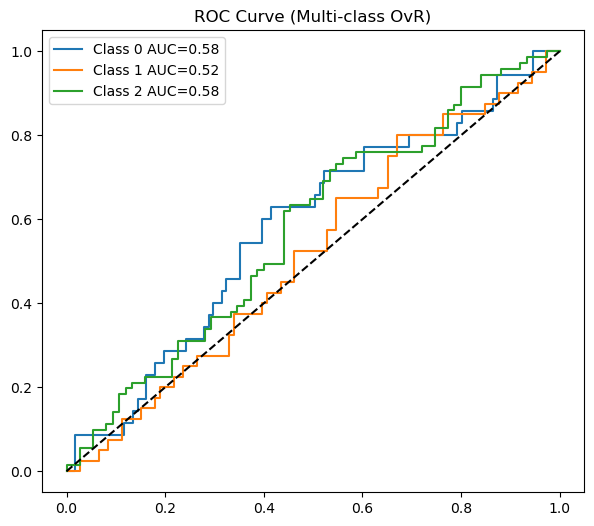

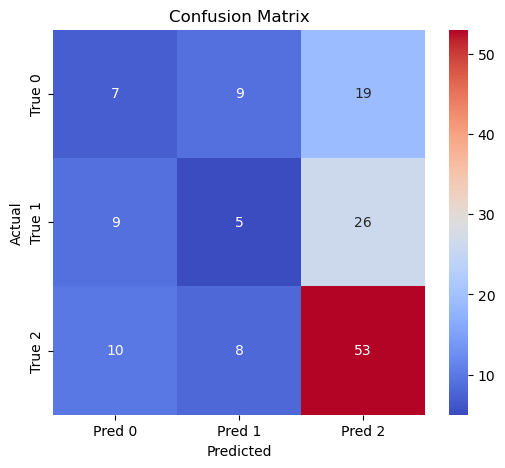

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(7,6))

y_bin = label_binarize(y_test, classes=np.unique(y_train))

for i in range(proba.shape[1]):
    fpr, tpr, _ = roc_curve(y_bin[:, i], proba[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} AUC={auc(fpr,tpr):.2f}")

plt.plot([0,1], [0,1], 'k--')
plt.legend()
plt.title("ROC Curve (Multi-class OvR)")
plt.show()

# Visualise confusion matrix as heatmap
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=[f'Pred {i}' for i in range(n_classes)],
            yticklabels=[f'True {i}' for i in range(n_classes)])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()